# PM5 – Task C: Compare Explicit vs. Implicit time domain ODE integrators

In [13]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.sparse.linalg import eigs
import time
from getParam_Sonar import getParam_Sonar
from eval_f_Sonar import eval_f_Sonar
from eval_u_Sonar import eval_u_Sonar
from eval_g_Sonar import eval_g_Sonar
from simpleLeapFrog import LeapfrogSolver
import scipy.sparse as sp

In [2]:
# Define the three grid configurations (optimized for 4 ppw @ 3 kHz)
grid_configs = {
    'small': {'Nx': 60, 'Nz': 30, 'Lx': 7.375, 'Lz': 3.625},
    'medium': {'Nx': 180, 'Nz': 120, 'Lx': 22.375, 'Lz': 14.875},
    'large': {'Nx': 360, 'Nz': 240, 'Lx': 44.875, 'Lz': 29.875}
}

# Initialize models
models = {}

# Signal properties from eval_u_Sonar
f_signal = 3000  # Hz
wavelength = 1500 / f_signal  # λ = c/f = 0.5 m
dt_nyquist = 1 / (2 * f_signal)  # 166.67 μs

print("=" * 80)
print("Setting up Sonar Models")
print("=" * 80)

for name, config in grid_configs.items():
    Nx, Nz = config['Nx'], config['Nz']
    
    # Get parameters
    p, x_start, t_start, t_stop, max_dt_FE = getParam_Sonar(
        Nx, Nz, config['Lx'], config['Lz'], UseSparseMatrices=True, alpha=0.1
    )
    
    N = Nx * Nz
    
    # Configure hydrophones at 1/3 and 2/3 of X domain
    hydro_1_x = Nx // 3
    hydro_2_x = 2 * Nx // 3
    
    # Source co-located with first hydrophone
    p['sonar_ix'] = hydro_1_x
    p['sonar_iz'] = Nz // 2
    source_idx = p['sonar_ix'] * Nz + p['sonar_iz']
    
    # Rebuild B matrix with new source location
    B_lil = sp.lil_matrix((2*N, 1), dtype=float)
    B_lil[N + source_idx, 0] = 1.0 / (p['dx'] * p['dz'])
    p['B'] = B_lil.tocsr()
    
    # Configure hydrophones
    p['hydrophones'] = {
        'z_pos': p['sonar_iz'],
        'x_indices': [hydro_1_x, hydro_2_x],
        'n_phones': 2
    }
    
    # Store model
    models[name] = {
        'p': p,
        'x_start': x_start,
        't_start': t_start,
        't_stop': t_stop,
        'max_dt_FE': max_dt_FE,
        'config': config
    }
    
    # Calculate metrics
    N_states = 2 * N
    ppw = wavelength / p['dx']
    nyquist_ok = max_dt_FE <= dt_nyquist
    separation_m = (hydro_2_x - hydro_1_x) * p['dx']
    delay_ms = separation_m / p['c'] * 1e3
    
    print(f"\n{name.upper()}: {Nx}×{Nz} = {N_states:,} states")
    print(f"  Domain: {config['Lx']:.1f}×{config['Lz']:.1f} m, dx={p['dx']*1e3:.1f} mm")
    print(f"  Resolution: {ppw:.1f} ppw, CFL={max_dt_FE*1e6:.1f} μs")
    print(f"  Nyquist: {'✓ PASS' if nyquist_ok else '✗ FAIL'} (limit={dt_nyquist*1e6:.1f} μs)")
    print(f"  Source/H1 at x={hydro_1_x*p['dx']:.1f}m, H2 at x={hydro_2_x*p['dx']:.1f}m")
    print(f"  Separation: {separation_m:.1f}m → delay ≈ {delay_ms:.2f} ms")

print("\n" + "=" * 80)

Setting up Sonar Models

SMALL: 60×30 = 3,600 states
  Domain: 7.4×3.6 m, dx=125.0 mm
  Resolution: 4.0 ppw, CFL=29.5 μs
  Nyquist: ✓ PASS (limit=166.7 μs)
  Source/H1 at x=2.5m, H2 at x=5.0m
  Separation: 2.5m → delay ≈ 1.67 ms

MEDIUM: 180×120 = 43,200 states
  Domain: 22.4×14.9 m, dx=125.0 mm
  Resolution: 4.0 ppw, CFL=29.5 μs
  Nyquist: ✓ PASS (limit=166.7 μs)
  Source/H1 at x=7.5m, H2 at x=15.0m
  Separation: 7.5m → delay ≈ 5.00 ms

LARGE: 360×240 = 172,800 states
  Domain: 44.9×29.9 m, dx=125.0 mm
  Resolution: 4.0 ppw, CFL=29.5 μs
  Nyquist: ✓ PASS (limit=166.7 μs)
  Source/H1 at x=15.0m, H2 at x=30.0m
  Separation: 15.0m → delay ≈ 10.00 ms


LARGE: 360×240 = 172,800 states
  Domain: 44.9×29.9 m, dx=125.0 mm
  Resolution: 4.0 ppw, CFL=29.5 μs
  Nyquist: ✓ PASS (limit=166.7 μs)
  Source/H1 at x=15.0m, H2 at x=30.0m
  Separation: 15.0m → delay ≈ 10.00 ms



## Sanity Check Models with Wave Visuals

Use Leapfrog integrator to generate solutions for all three grids and verify the models are working correctly.

### Small Grid Reference

Small grid: 334 steps at dt=14.73 μs
Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first step...
Running 333 leapfrog steps...
Leapfrog integration complete!
✓ Complete in 0.04s


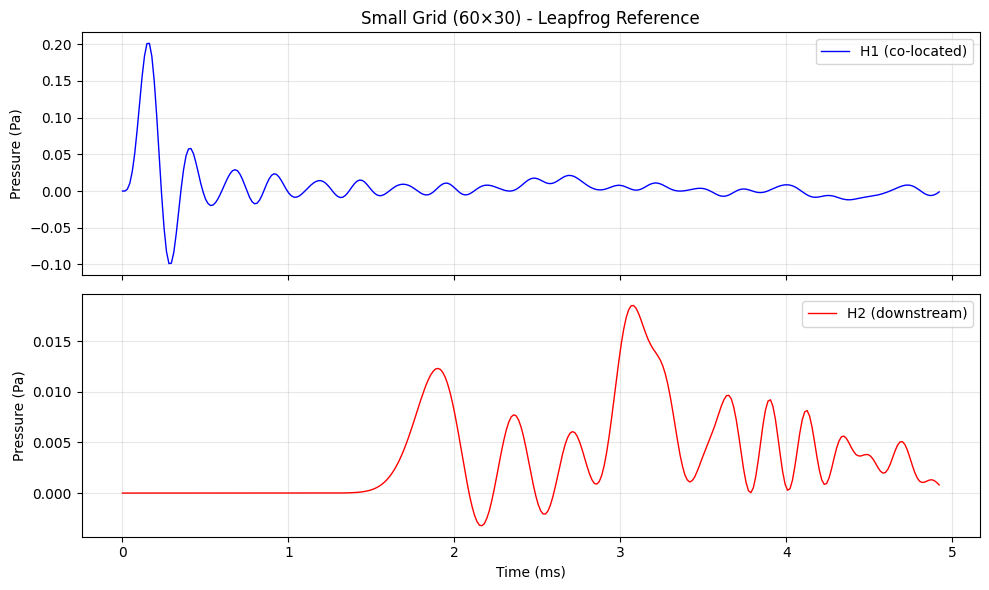

In [14]:
# Run Leapfrog solver for small grid
model = models['small']
p = model['p']
t_start, t_stop = model['t_start'], model['t_stop']

# Use half CFL timestep for safety
dt = model['max_dt_FE'] * 0.5
num_steps = int(np.ceil((t_stop - t_start) / dt))

print(f"Small grid: {num_steps} steps at dt={dt*1e6:.2f} μs")

# Scaled input
amplitude = 1e6
eval_u_scaled = lambda t: amplitude * eval_u_Sonar(t)

# Run Leapfrog
t0 = time.perf_counter()
X_small, t_small = LeapfrogSolver(
    eval_f_Sonar,
    model['x_start'],
    p,
    eval_u_scaled,
    num_steps,
    dt,
    visualize=False,
    verbose=False
)
runtime = time.perf_counter() - t0

# Extract hydrophone signals
y_small = np.zeros((2, len(t_small)))
for i in range(len(t_small)):
    y_small[:, i] = eval_g_Sonar(X_small[:, i].reshape(-1, 1), p).flatten()

print(f"✓ Complete in {runtime:.2f}s")

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax1.plot(t_small*1e3, y_small[0, :], 'b-', linewidth=1, label='H1 (co-located)')
ax1.set_ylabel('Pressure (Pa)')
ax1.set_title(f'Small Grid ({p["Nx"]}×{p["Nz"]}) - Leapfrog Reference')
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.plot(t_small*1e3, y_small[1, :], 'r-', linewidth=1, label='H2 (downstream)')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Pressure (Pa)')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

### Medium Grid Reference

Medium grid: 1013 steps at dt=14.73 μs
Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first step...
Running 1012 leapfrog steps...
Leapfrog integration complete!
✓ Complete in 1.75s
Leapfrog integration complete!
✓ Complete in 1.75s


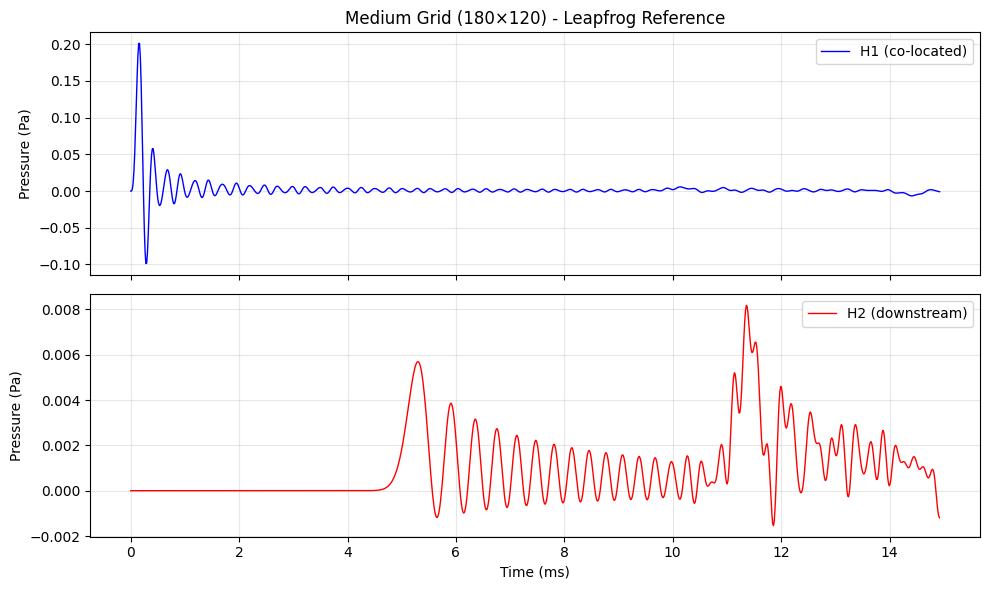

In [15]:
# Run Leapfrog solver for medium grid
model = models['medium']
p = model['p']
t_start, t_stop = model['t_start'], model['t_stop']

# Use half CFL timestep for safety
dt = model['max_dt_FE'] * 0.5
num_steps = int(np.ceil((t_stop - t_start) / dt))

print(f"Medium grid: {num_steps} steps at dt={dt*1e6:.2f} μs")

t0 = time.perf_counter()
X_medium, t_medium = LeapfrogSolver(
    eval_f_Sonar,
    model['x_start'],
    p,
    eval_u_scaled,
    num_steps,
    dt,
    visualize=False,
    verbose=False
)
runtime = time.perf_counter() - t0

# Extract hydrophone signals
y_medium = np.zeros((2, len(t_medium)))
for i in range(len(t_medium)):
    y_medium[:, i] = eval_g_Sonar(X_medium[:, i].reshape(-1, 1), p).flatten()

print(f"✓ Complete in {runtime:.2f}s")

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax1.plot(t_medium*1e3, y_medium[0, :], 'b-', linewidth=1, label='H1 (co-located)')
ax1.set_ylabel('Pressure (Pa)')
ax1.set_title(f'Medium Grid ({p["Nx"]}×{p["Nz"]}) - Leapfrog Reference')
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.plot(t_medium*1e3, y_medium[1, :], 'r-', linewidth=1, label='H2 (downstream)')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Pressure (Pa)')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

### Large Grid Reference

Large grid: 2031 steps at dt=14.73 μs
Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first step...
Running 2030 leapfrog steps...
Leapfrog integration complete!
✓ Complete in 33.10s
Leapfrog integration complete!
✓ Complete in 33.10s


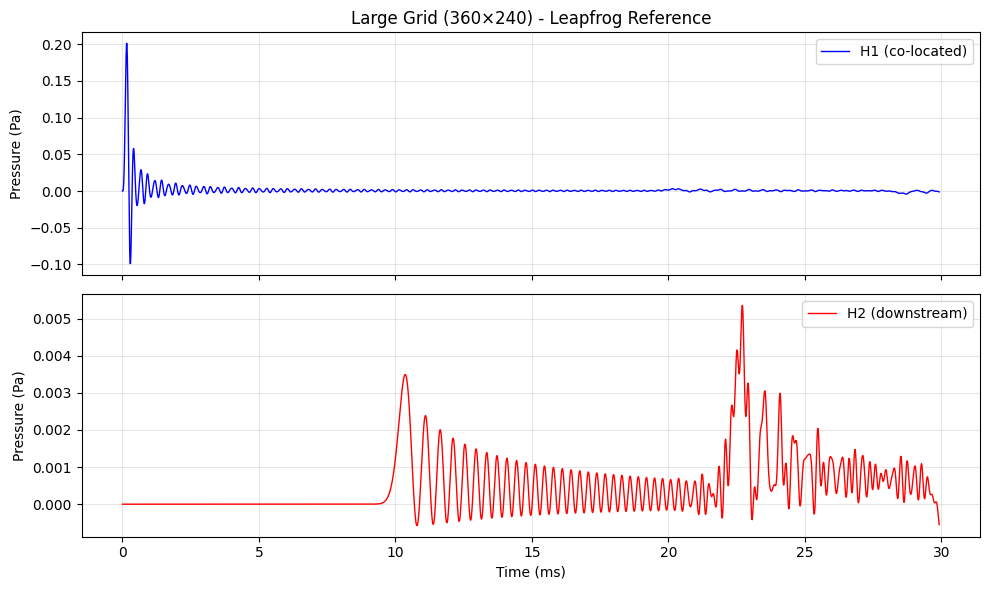

In [5]:
# Run Leapfrog solver for large grid
model = models['large']
p = model['p']
t_start, t_stop = model['t_start'], model['t_stop']

# Use half CFL timestep for safety
dt = model['max_dt_FE'] * 0.5
num_steps = int(np.ceil((t_stop - t_start) / dt))

print(f"Large grid: {num_steps} steps at dt={dt*1e6:.2f} μs")

t0 = time.perf_counter()
X_large, t_large = LeapfrogSolver(
    eval_f_Sonar,
    model['x_start'],
    p,
    eval_u_scaled,
    num_steps,
    dt,
    visualize=False,
    verbose=False
)
runtime = time.perf_counter() - t0

# Extract hydrophone signals
y_large = np.zeros((2, len(t_large)))
for i in range(len(t_large)):
    y_large[:, i] = eval_g_Sonar(X_large[:, i].reshape(-1, 1), p).flatten()

print(f"✓ Complete in {runtime:.2f}s")

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax1.plot(t_large*1e3, y_large[0, :], 'b-', linewidth=1, label='H1 (co-located)')
ax1.set_ylabel('Pressure (Pa)')
ax1.set_title(f'Large Grid ({p["Nx"]}×{p["Nz"]}) - Leapfrog Reference')
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.plot(t_large*1e3, y_large[1, :], 'r-', linewidth=1, label='H2 (downstream)')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Pressure (Pa)')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Stability Plots

In [10]:
def plot_stability_regions(model_name, p, max_dt_FE, dt_test_factors=[0.1, 0.5, 1.0, 2.0]):
    """
    Plot eigenvalues and stability regions for different integrators.
    
    Parameters:
    -----------
    model_name : str
        Name of the model (small/medium/large)
    p : dict
        Parameter dictionary containing A matrix
    max_dt_FE : float
        CFL-limited timestep for Forward Euler
    dt_test_factors : list
        Multiples of max_dt_FE to test (e.g., [0.1, 0.5, 1.0])
    """
    
    print(f"Computing eigenvalues for {model_name} grid...")
    
    # Compute largest-magnitude eigenvalues (sparse matrix)
    n_eigs = min(200, p['A'].shape[0] - 2)
    
    try:
        eigvals, _ = eigs(p['A'], k=n_eigs, which='LM')
        print(f"  ✓ Computed {len(eigvals)} eigenvalues\n")
        
        # Analyze eigenvalue structure (UNSCALED - from system matrix A)
        real_parts = np.real(eigvals)
        imag_parts = np.imag(eigvals)
        
        print(f"  Eigenvalue Analysis (UNSCALED system matrix A):")
        print(f"  {'─'*50}")
        
        # Check for positive real parts (unstable modes)
        pos_real = real_parts[real_parts > 1e-10]
        if len(pos_real) > 0:
            max_pos_real = np.max(pos_real)
            print(f"  ⚠️  Positive real parts: {len(pos_real)} eigenvalues")
            print(f"      Largest Re(λ): {max_pos_real:.3e} (unstable!)")
        else:
            print(f"  ✓ No positive real parts → stable system")
        
        # Check for negative real parts (damped modes)
        neg_real = real_parts[real_parts < -1e-10]
        if len(neg_real) > 0:
            max_neg_real = np.min(neg_real)
            print(f"  ✓ Negative real parts: {len(neg_real)} eigenvalues")
            print(f"      Largest magnitude Re(λ): {max_neg_real:.3e} (damping)")
        else:
            print(f"  ⚠️  No negative real parts → undamped system")
        
        # Imaginary eigenvalues (oscillatory modes)
        max_imag = np.max(np.abs(imag_parts))
        max_imag_freq = max_imag / (2 * np.pi)
        print(f"  ✓ Largest |Im(λ)|: {max_imag:.3e} rad/s")
        print(f"      Frequency: {max_imag_freq:.1f} Hz")
        print(f"  ✓ λ_max (magnitude): {np.max(np.abs(eigvals)):.3e}")
        print(f"  {'─'*50}\n")
        
    except Exception as e:
        print(f"  ⚠️  Eigenvalue computation failed: {e}")
        return
    
    # Create figure - 2x2 grid for different timesteps
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # Plot stability regions for different timesteps
    for idx, dt_factor in enumerate(dt_test_factors[:4]):
        ax = axes.flatten()[idx]
        dt = max_dt_FE * dt_factor
        
        # Scale eigenvalues: z = λ·Δt
        z = eigvals * dt
        
        # Plot scaled eigenvalues
        ax.scatter(np.real(z), np.imag(z), s=20, alpha=0.6, c='blue', 
                   label=f'λ·Δt (Δt={dt*1e6:.1f}μs)', zorder=10)
        
        # Draw stability region boundaries
        theta = np.linspace(0, 2*np.pi, 1000)
        
        # Forward Euler: circle centered at (-1, 0) with radius 1
        fe_x = -1 + np.cos(theta)
        fe_y = np.sin(theta)
        ax.fill(fe_x, fe_y, alpha=0.2, color='green', label='FE stable', zorder=1)
        ax.plot(fe_x, fe_y, 'g-', linewidth=2, zorder=5)
        
        # Leapfrog: purely imaginary axis (|Im(z)| ≤ 1)
        ax.fill_betweenx([-1, 1], -0.05, 0.05, alpha=0.2, color='cyan', 
                         label='Leapfrog stable', zorder=2)
        ax.axvline(x=0, color='cyan', linewidth=2, linestyle='-', alpha=0.7, zorder=6)
        ax.axhline(y=1, color='cyan', linewidth=1, linestyle='--', alpha=0.5, zorder=6)
        ax.axhline(y=-1, color='cyan', linewidth=1, linestyle='--', alpha=0.5, zorder=6)
        
        # Backward Euler: entire left half-plane
        ylim = 3
        be_boundary_y = np.linspace(-ylim, ylim, 100)
        ax.fill_betweenx(be_boundary_y, -5, 0, alpha=0.15, color='orange', 
                         label='BE stable', zorder=2)
        ax.axvline(x=0, color='orange', linewidth=2, linestyle='-', zorder=6)
        
        # Trapezoidal: entire left half-plane + imaginary axis (A-stable)
        ax.axvline(x=0, color='purple', linewidth=2, linestyle='--', 
                   label='TR stable', zorder=7)
        
        ax.axhline(y=0, color='k', linewidth=0.5, linestyle='--', alpha=0.3)
        ax.axvline(x=0, color='k', linewidth=0.5, linestyle='--', alpha=0.3)
        ax.set_xlabel('Re(λ·Δt)', fontsize=11)
        ax.set_ylabel('Im(λ·Δt)', fontsize=11)
        
        # Stability checks
        fe_stable = np.all(np.abs(1 + z) <= 1.0)
        lf_stable = np.all((np.abs(np.real(z)) < 1e-6) & (np.abs(np.imag(z)) <= 1.0))
        
        status_fe = "✓" if fe_stable else "✗"
        status_lf = "✓" if lf_stable else "✗"
        
        ax.set_title(f'Δt={dt_factor:.1f}×CFL ({dt*1e6:.1f}μs) | FE:{status_fe} LF:{status_lf}', 
                     fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right', fontsize=8)
        ax.set_xlim(-3, 1)
        ax.set_ylim(-2, 2)
        ax.set_aspect('equal', adjustable='box')
    
    plt.suptitle(f'{model_name.upper()} Grid: Eigenvalue Stability Analysis', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Summary
    print(f"\n{'='*60}")
    print(f"STABILITY SUMMARY for {model_name.upper()}")
    print(f"{'='*60}")
    print(f"CFL-limited timestep: {max_dt_FE*1e6:.2f} μs")
    
    for dt_factor in dt_test_factors:
        dt = max_dt_FE * dt_factor
        z = eigvals * dt
        
        fe_stable = np.all(np.abs(1 + z) <= 1.0)
        lf_stable = np.all((np.abs(np.real(z)) < 1e-6) & (np.abs(np.imag(z)) <= 1.0))
        
        print(f"\nΔt = {dt_factor:.1f}×CFL ({dt*1e6:.1f} μs):")
        print(f"  FE:       {'✓ Stable' if fe_stable else '✗ Unstable'}")
        print(f"  Leapfrog: {'✓ Stable' if lf_stable else '✗ Unstable (has damping)'}")
        print(f"  BE:       ✓ Stable (A-stable)")
        print(f"  TR:       ✓ Stable (A-stable)")

Computing eigenvalues for small grid...
  ✓ Computed 200 eigenvalues

  Eigenvalue Analysis (UNSCALED system matrix A):
  ──────────────────────────────────────────────────
  ✓ No positive real parts → stable system
  ✓ Negative real parts: 200 eigenvalues
      Largest magnitude Re(λ): -5.001e-02 (damping)
  ✓ Largest |Im(λ)|: 4.049e+04 rad/s
      Frequency: 6444.2 Hz
  ✓ λ_max (magnitude): 4.049e+04
  ──────────────────────────────────────────────────

  ✓ Computed 200 eigenvalues

  Eigenvalue Analysis (UNSCALED system matrix A):
  ──────────────────────────────────────────────────
  ✓ No positive real parts → stable system
  ✓ Negative real parts: 200 eigenvalues
      Largest magnitude Re(λ): -5.001e-02 (damping)
  ✓ Largest |Im(λ)|: 4.049e+04 rad/s
      Frequency: 6444.2 Hz
  ✓ λ_max (magnitude): 4.049e+04
  ──────────────────────────────────────────────────



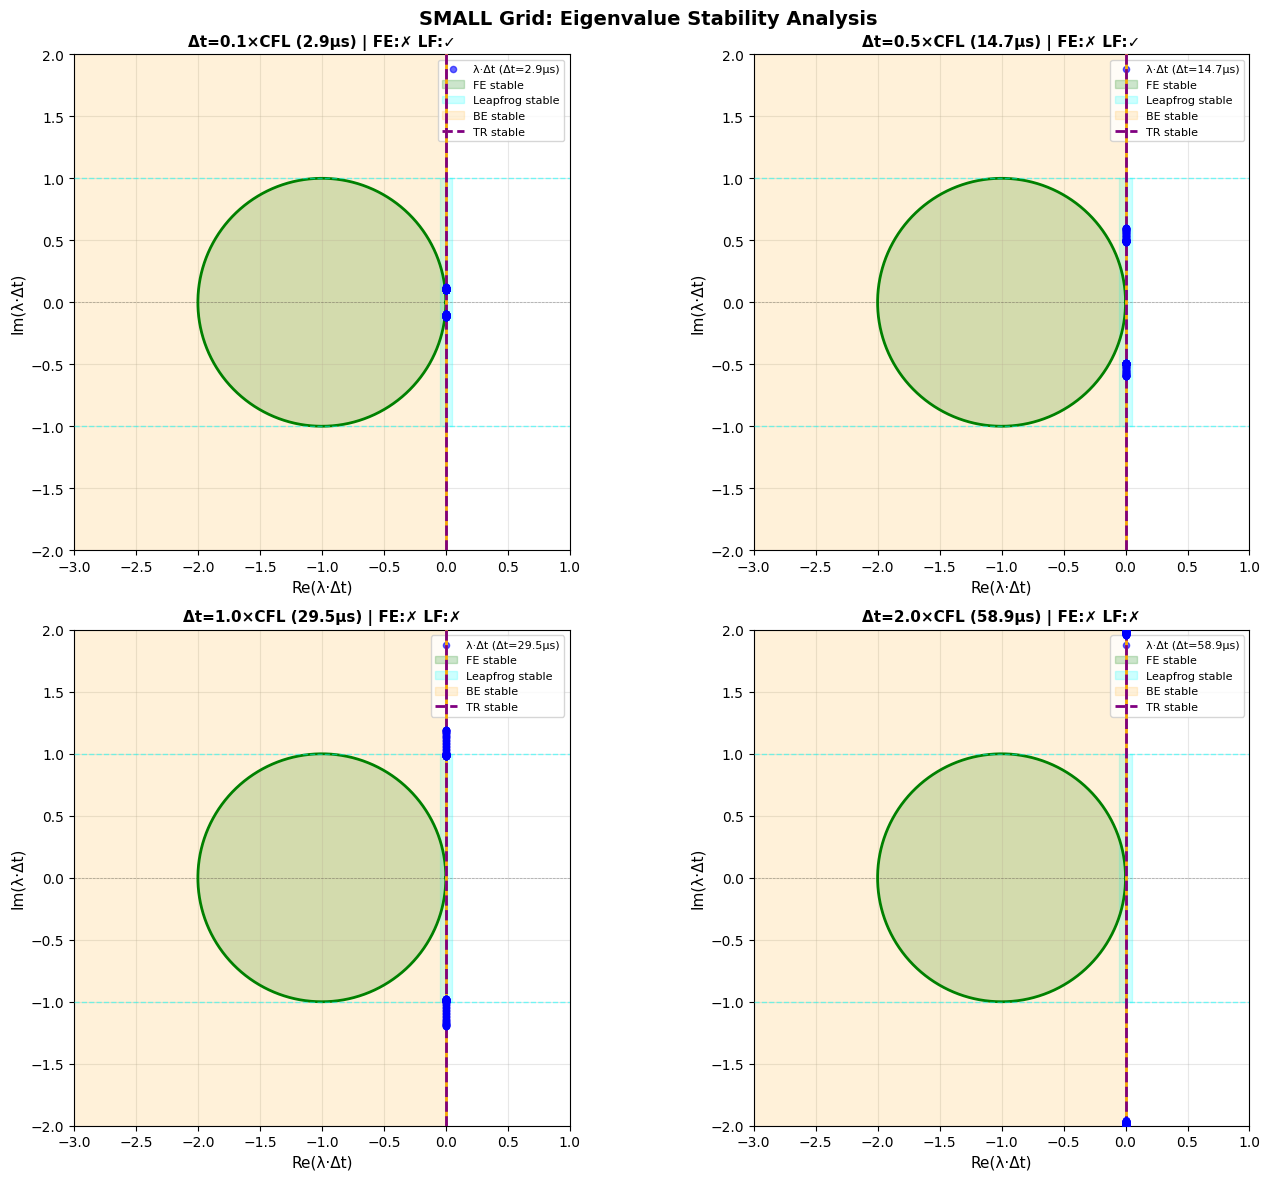


STABILITY SUMMARY for SMALL
CFL-limited timestep: 29.46 μs

Δt = 0.1×CFL (2.9 μs):
  FE:       ✗ Unstable
  Leapfrog: ✓ Stable
  BE:       ✓ Stable (A-stable)
  TR:       ✓ Stable (A-stable)

Δt = 0.5×CFL (14.7 μs):
  FE:       ✗ Unstable
  Leapfrog: ✓ Stable
  BE:       ✓ Stable (A-stable)
  TR:       ✓ Stable (A-stable)

Δt = 1.0×CFL (29.5 μs):
  FE:       ✗ Unstable
  Leapfrog: ✗ Unstable (has damping)
  BE:       ✓ Stable (A-stable)
  TR:       ✓ Stable (A-stable)

Δt = 2.0×CFL (58.9 μs):
  FE:       ✗ Unstable
  Leapfrog: ✗ Unstable (has damping)
  BE:       ✓ Stable (A-stable)
  TR:       ✓ Stable (A-stable)


In [11]:
# Run stability analysis for small grid
model = models['small']
plot_stability_regions(
    model_name='small',
    p=model['p'],
    max_dt_FE=model['max_dt_FE'],
    dt_test_factors=[0.1, 0.5, 1.0, 2.0]
)

Computing eigenvalues for large grid...
  ✓ Computed 200 eigenvalues

  Eigenvalue Analysis (UNSCALED system matrix A):
  ──────────────────────────────────────────────────
  ✓ No positive real parts → stable system
  ✓ Negative real parts: 200 eigenvalues
      Largest magnitude Re(λ): -5.001e-02 (damping)
  ✓ Largest |Im(λ)|: 4.049e+04 rad/s
      Frequency: 6444.2 Hz
  ✓ λ_max (magnitude): 4.049e+04
  ──────────────────────────────────────────────────

  ✓ Computed 200 eigenvalues

  Eigenvalue Analysis (UNSCALED system matrix A):
  ──────────────────────────────────────────────────
  ✓ No positive real parts → stable system
  ✓ Negative real parts: 200 eigenvalues
      Largest magnitude Re(λ): -5.001e-02 (damping)
  ✓ Largest |Im(λ)|: 4.049e+04 rad/s
      Frequency: 6444.2 Hz
  ✓ λ_max (magnitude): 4.049e+04
  ──────────────────────────────────────────────────



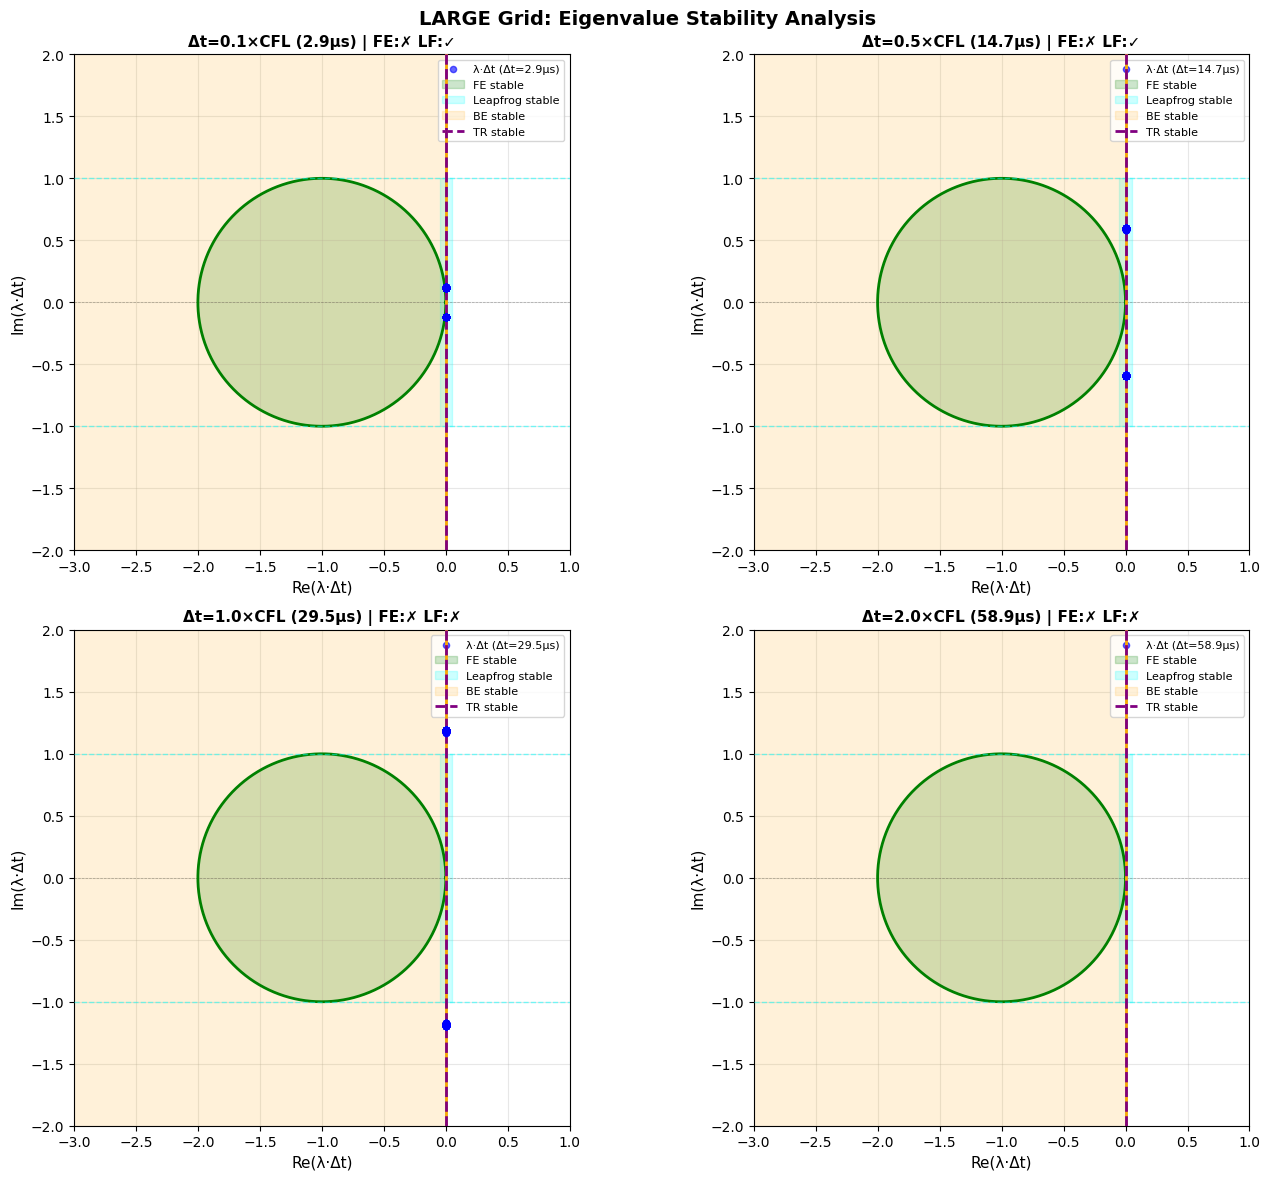


STABILITY SUMMARY for LARGE
CFL-limited timestep: 29.46 μs

Δt = 0.1×CFL (2.9 μs):
  FE:       ✗ Unstable
  Leapfrog: ✓ Stable
  BE:       ✓ Stable (A-stable)
  TR:       ✓ Stable (A-stable)

Δt = 0.5×CFL (14.7 μs):
  FE:       ✗ Unstable
  Leapfrog: ✓ Stable
  BE:       ✓ Stable (A-stable)
  TR:       ✓ Stable (A-stable)

Δt = 1.0×CFL (29.5 μs):
  FE:       ✗ Unstable
  Leapfrog: ✗ Unstable (has damping)
  BE:       ✓ Stable (A-stable)
  TR:       ✓ Stable (A-stable)

Δt = 2.0×CFL (58.9 μs):
  FE:       ✗ Unstable
  Leapfrog: ✗ Unstable (has damping)
  BE:       ✓ Stable (A-stable)
  TR:       ✓ Stable (A-stable)


In [12]:
# Run stability analysis for large grid
model = models['large']
plot_stability_regions(
    model_name='large',
    p=model['p'],
    max_dt_FE=model['max_dt_FE'],
    dt_test_factors=[0.1, 0.5, 1.0, 2.0]
)

# Golden Reference collection with Leapfrog

In [16]:
import os
import pickle

def save_leapfrog_reference(model_name, model, dt_factor=0.5, eval_u=None, amplitude=1e6, 
                            output_dir='ODErefs', visualize=False, verbose=True):
    """
    Run Leapfrog solver and save reference solution to disk.
    
    Parameters:
    -----------
    model_name : str
        Name of the model ('small', 'medium', 'large')
    model : dict
        Model dictionary containing p, x_start, t_start, t_stop, max_dt_FE
    dt_factor : float
        Multiplier for max_dt_FE timestep (default: 0.5 for safety)
    eval_u : callable, optional
        Input function u(t). If None, uses eval_u_Sonar with amplitude scaling
    amplitude : float
        Scaling factor for input signal (default: 1e6)
    output_dir : str
        Directory to save reference solutions
    visualize : bool
        Whether to visualize during Leapfrog integration
    verbose : bool
        Whether to print progress messages
    
    Returns:
    --------
    filepath : str
        Path to saved file
    X : ndarray
        State history array
    t : ndarray
        Time array
    """
    
    p = model['p']
    t_start, t_stop = model['t_start'], model['t_stop']
    
    # Calculate timestep and number of steps
    dt = model['max_dt_FE'] * dt_factor
    num_steps = int(np.ceil((t_stop - t_start) / dt))
    
    if verbose:
        print(f"\n{'='*60}")
        print(f"Running Leapfrog for {model_name.upper()} grid")
        print(f"{'='*60}")
        print(f"  Timestep: {dt*1e6:.2f} μs ({dt_factor:.2f}×CFL)")
        print(f"  Steps: {num_steps}")
        print(f"  Duration: {t_stop*1e3:.2f} ms")
    
    # Setup input function
    if eval_u is None:
        eval_u_scaled = lambda t: amplitude * eval_u_Sonar(t)
    else:
        eval_u_scaled = eval_u
    
    # Run Leapfrog solver
    t0 = time.perf_counter()
    X, t = LeapfrogSolver(
        eval_f_Sonar,
        model['x_start'],
        p,
        eval_u_scaled,
        num_steps,
        dt,
        visualize=visualize,
        verbose=False
    )
    runtime = time.perf_counter() - t0
    
    if verbose:
        print(f"  ✓ Complete in {runtime:.2f}s")
        print(f"  State array: {X.shape}")
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Package all data
    ref_data = {
        'model_name': model_name,
        'X': X,                    # State history
        't': t,                    # Time array
        'dt': dt,                  # Timestep
        'dt_factor': dt_factor,    # Factor used
        'num_steps': num_steps,    # Number of steps
        'runtime': runtime,        # Computation time
        'amplitude': amplitude,    # Input scaling
        'p': model['p'],           # Parameters (includes A, B, C, hydrophones, etc.)
        'x_start': model['x_start'],
        't_start': model['t_start'],
        't_stop': model['t_stop'],
        'max_dt_FE': model['max_dt_FE'],
        'config': model['config'], # Grid configuration
        'solver': 'Leapfrog',
        'version': '1.0'
    }
    
    # Save to file
    filename = f'leapfrog_{model_name}_dt{dt*1e6:.1f}us.pkl'
    filepath = os.path.join(output_dir, filename)
    
    with open(filepath, 'wb') as f:
        pickle.dump(ref_data, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    if verbose:
        print(f"  ✓ Saved: {filepath}")
        print(f"  File size: {os.path.getsize(filepath) / 1e6:.2f} MB")
        print(f"{'='*60}\n")
    
    return filepath, X, t


def load_leapfrog_reference(model_name, dt=None, output_dir='ODErefs'):
    """
    Load Leapfrog reference solution from disk.
    
    Parameters:
    -----------
    model_name : str
        Name of the model ('small', 'medium', 'large')
    dt : float, optional
        Specific timestep to load. If None, finds the first match.
    output_dir : str
        Directory containing reference solutions
    
    Returns:
    --------
    ref_data : dict
        Dictionary containing X, t, p, and other metadata
    """
    
    if not os.path.exists(output_dir):
        raise FileNotFoundError(f"Reference directory not found: {output_dir}")
    
    # Find matching file
    if dt is not None:
        filename = f'leapfrog_{model_name}_dt{dt*1e6:.1f}us.pkl'
        filepath = os.path.join(output_dir, filename)
        
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"Reference file not found: {filepath}")
    else:
        # Find any file matching model_name
        import glob
        pattern = os.path.join(output_dir, f'leapfrog_{model_name}_*.pkl')
        matches = glob.glob(pattern)
        
        if not matches:
            raise FileNotFoundError(f"No reference files found for model: {model_name}")
        
        filepath = matches[0]
        if len(matches) > 1:
            print(f"⚠️  Multiple references found, loading: {os.path.basename(filepath)}")
    
    # Load data
    with open(filepath, 'rb') as f:
        ref_data = pickle.load(f)
    
    print(f"✓ Loaded reference: {filepath}")
    print(f"  Solver: {ref_data.get('solver', 'Unknown')}")
    print(f"  States: {ref_data['X'].shape}, dt={ref_data['dt']*1e6:.1f} μs")
    print(f"  Time: [{ref_data['t'][0]*1e3:.2f}, {ref_data['t'][-1]*1e3:.2f}] ms")
    print(f"  Runtime: {ref_data['runtime']:.2f} s")
    
    return ref_data

In [17]:
# Generate and save all three reference solutions
# Use dt = 0.25×CFL for extra safety margin

for model_name in ['small', 'medium', 'large']:
    filepath, X_ref, t_ref = save_leapfrog_reference(
        model_name=model_name,
        model=models[model_name],
        dt_factor=0.1,  # Extra conservative timestep for golden reference
        amplitude=1e6,   # Same scaling as in earlier simulations
        visualize=False,
        verbose=True
    )


Running Leapfrog for SMALL grid
  Timestep: 7.37 μs (0.25×CFL)
  Steps: 668
  Duration: 4.92 ms
Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first step...
Running 667 leapfrog steps...
Leapfrog integration complete!
  ✓ Complete in 0.09s
  State array: (3600, 669)
  ✓ Saved: ODErefs\leapfrog_small_dt7.4us.pkl
  File size: 19.48 MB


Running Leapfrog for MEDIUM grid
  Timestep: 7.37 μs (0.25×CFL)
  Steps: 2026
  Duration: 14.92 ms
Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first step...
Running 2025 leapfrog steps...
Leapfrog integration complete!
  ✓ Complete in 3.65s
  State array: (43200, 2027)
Leapfrog integration complete!
  ✓ Complete in 3.65s
  State array: (43200, 2027)
  ✓ Saved: ODErefs\leapfrog_medium_dt7.4us.pkl
  File size: 703.05 MB


Running Leapfrog for LARGE grid
  Timestep: 7.37 μs (0.25×CFL)
  Steps: 4062
  Duration: 29.92 ms
Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first ste

## Verify Loaded Reference Solutions

Load the saved reference solutions and visualize to confirm they match expected wave propagation.

✓ Loaded reference: ODErefs\leapfrog_small_dt7.4us.pkl
  Solver: Leapfrog
  States: (3600, 669), dt=7.4 μs
  Time: [0.00, 4.92] ms
  Runtime: 0.09 s


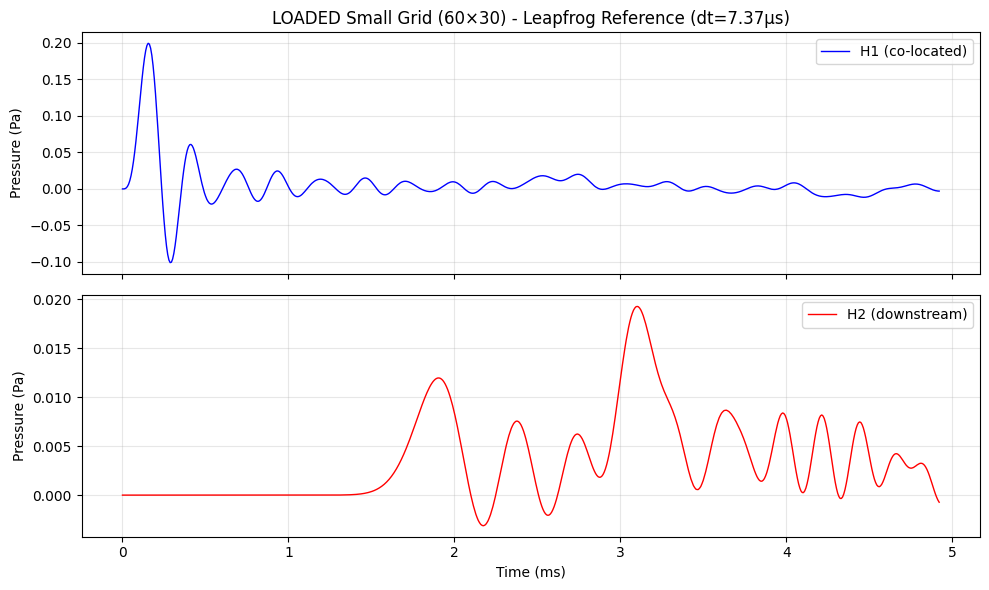

In [18]:
# Load and visualize the small grid reference
ref_small = load_leapfrog_reference('small')

# Extract data
X_ref_small = ref_small['X']
t_ref_small = ref_small['t']
p_ref_small = ref_small['p']

# Extract hydrophone signals
y_ref_small = np.zeros((2, len(t_ref_small)))
for i in range(len(t_ref_small)):
    y_ref_small[:, i] = eval_g_Sonar(X_ref_small[:, i].reshape(-1, 1), p_ref_small).flatten()

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax1.plot(t_ref_small*1e3, y_ref_small[0, :], 'b-', linewidth=1, label='H1 (co-located)')
ax1.set_ylabel('Pressure (Pa)')
ax1.set_title(f'LOADED Small Grid ({p_ref_small["Nx"]}×{p_ref_small["Nz"]}) - Leapfrog Reference (dt={ref_small["dt"]*1e6:.2f}μs)')
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.plot(t_ref_small*1e3, y_ref_small[1, :], 'r-', linewidth=1, label='H2 (downstream)')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Pressure (Pa)')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

✓ Loaded reference: ODErefs\leapfrog_medium_dt7.4us.pkl
  Solver: Leapfrog
  States: (43200, 2027), dt=7.4 μs
  Time: [0.00, 14.92] ms
  Runtime: 3.65 s


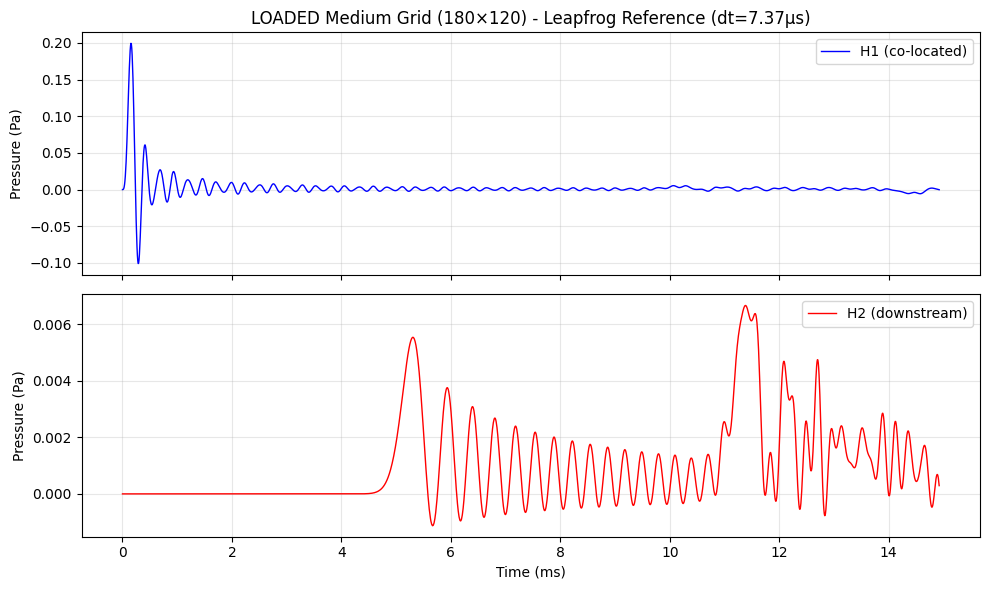

In [19]:
# Load and visualize the medium grid reference
ref_medium = load_leapfrog_reference('medium')

# Extract data
X_ref_medium = ref_medium['X']
t_ref_medium = ref_medium['t']
p_ref_medium = ref_medium['p']

# Extract hydrophone signals
y_ref_medium = np.zeros((2, len(t_ref_medium)))
for i in range(len(t_ref_medium)):
    y_ref_medium[:, i] = eval_g_Sonar(X_ref_medium[:, i].reshape(-1, 1), p_ref_medium).flatten()

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax1.plot(t_ref_medium*1e3, y_ref_medium[0, :], 'b-', linewidth=1, label='H1 (co-located)')
ax1.set_ylabel('Pressure (Pa)')
ax1.set_title(f'LOADED Medium Grid ({p_ref_medium["Nx"]}×{p_ref_medium["Nz"]}) - Leapfrog Reference (dt={ref_medium["dt"]*1e6:.2f}μs)')
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.plot(t_ref_medium*1e3, y_ref_medium[1, :], 'r-', linewidth=1, label='H2 (downstream)')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Pressure (Pa)')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

✓ Loaded reference: ODErefs\leapfrog_large_dt7.4us.pkl
  Solver: Leapfrog
  States: (172800, 4063), dt=7.4 μs
  Time: [0.00, 29.92] ms
  Runtime: 54.07 s


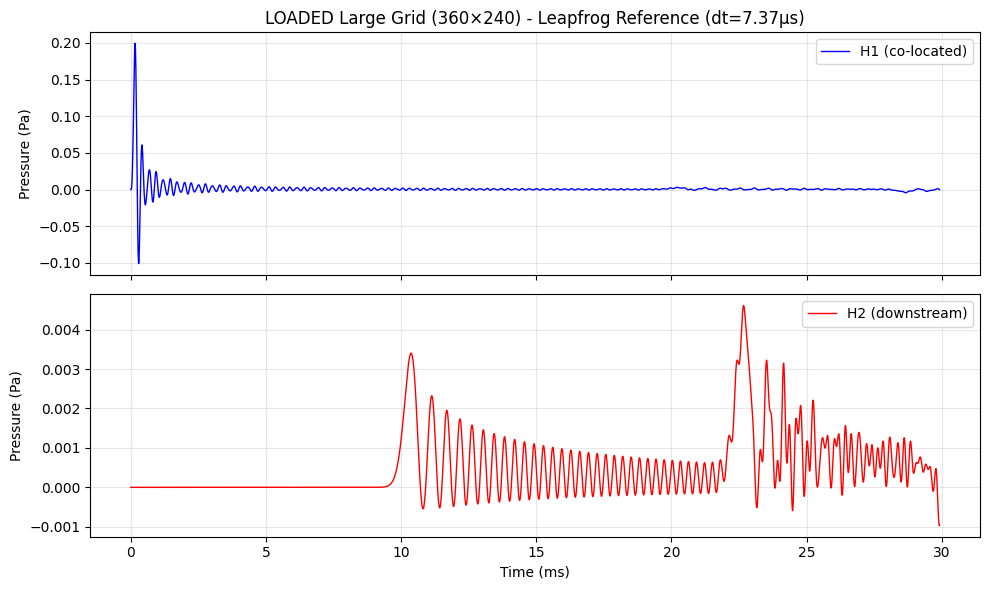

In [20]:
# Load and visualize the large grid reference
ref_large = load_leapfrog_reference('large')

# Extract data
X_ref_large = ref_large['X']
t_ref_large = ref_large['t']
p_ref_large = ref_large['p']

# Extract hydrophone signals
y_ref_large = np.zeros((2, len(t_ref_large)))
for i in range(len(t_ref_large)):
    y_ref_large[:, i] = eval_g_Sonar(X_ref_large[:, i].reshape(-1, 1), p_ref_large).flatten()

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax1.plot(t_ref_large*1e3, y_ref_large[0, :], 'b-', linewidth=1, label='H1 (co-located)')
ax1.set_ylabel('Pressure (Pa)')
ax1.set_title(f'LOADED Large Grid ({p_ref_large["Nx"]}×{p_ref_large["Nz"]}) - Leapfrog Reference (dt={ref_large["dt"]*1e6:.2f}μs)')
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.plot(t_ref_large*1e3, y_ref_large[1, :], 'r-', linewidth=1, label='H2 (downstream)')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Pressure (Pa)')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Trapezoidal Rule Comparison

Compare reference solution against fixed-timestep Trapezoidal (implicit midpoint) solver from `scipy.integrate.solve_ivp`.

In [35]:
# Setup RHS function for solve_ivp (requires 1D array format)
def rhs_sonar(t, x, p, eval_u, amplitude):
    """
    RHS function for scipy.integrate.solve_ivp.
    
    Parameters:
    -----------
    t : float
        Current time
    x : ndarray (1D)
        State vector (flattened)
    p : dict
        Parameter dictionary
    eval_u : callable
        Input function
    amplitude : float
        Scaling for input
        
    Returns:
    --------
    dxdt : ndarray (1D)
        Time derivative of state (flattened)
    """
    x_col = x.reshape(-1, 1)
    u_val = amplitude * eval_u(t)
    # eval_f_Sonar expects: eval_f_Sonar(x, p, u) where u is a callable
    # So we create a lambda that returns the constant u_val
    dxdt = eval_f_Sonar(x_col, p, u_val)
    return dxdt.flatten()

# Jacobian function (system matrix A, constant in time)
def jac_sonar(t, x, p):
    """
    Jacobian matrix for the linear system.
    Since dx/dt = A*x + B*u(t), the Jacobian is just A.
    Returns sparse CSR matrix for efficiency.
    """
    return p['A']  # Already in CSR format from getParam_Sonar

print("✓ RHS and Jacobian functions defined for solve_ivp")
print(f"  Note: Jacobian will be provided as sparse CSR matrix for efficiency\n")

# Run Trapezoidal solver on small grid at dt = 1.0×CFL
model = models['small']
p = model['p']
amplitude = 1e6

# Load reference solution
ref_small = load_leapfrog_reference('small')

# Set timestep to 1.0×CFL (testing at stability limit)
dt_trap = model['max_dt_FE'] * 1.0
t_start = model['t_start']
t_stop = model['t_stop']

# Create time array for evaluation points
num_steps = int(np.floor((t_stop - t_start) / dt_trap))
t_eval = np.linspace(t_start, t_start + num_steps * dt_trap, num_steps + 1)
t_eval = t_eval[t_eval <= t_stop]  # Ensure we don't exceed t_stop

print(f"{'='*60}")
print(f"Radau Solver - Small Grid (Implicit A-stable)")
print(f"{'='*60}")
print(f"  Timestep: {dt_trap*1e6:.2f} μs (1.0×CFL)")
print(f"  Evaluation points: {len(t_eval)}")
print(f"  Duration: {t_stop*1e3:.2f} ms")
print(f"  Reference dt: {ref_small['dt']*1e6:.2f} μs ({ref_small['dt_factor']:.2f}×CFL)")
print(f"\n  Note: Radau is adaptive but constrained by max_step parameter")

# Run Radau solver (implicit, A-stable, 5th order)
t0 = time.perf_counter()
sol_radau = solve_ivp(
    fun=lambda t, x: rhs_sonar(t, x, p, eval_u_Sonar, amplitude),
    t_span=(t_start, t_stop),
    y0=model['x_start'].flatten(),
    method='Radau',
    t_eval=t_eval,
    jac=lambda t, x: jac_sonar(t, x, p),
    max_step=dt_trap,
    rtol=1e-6,
    atol=1e-8
)
runtime_radau = time.perf_counter() - t0

print(f"\n{'='*60}")
print(f"Solver Results")
print(f"{'='*60}")
print(f"  Status: {sol_radau.message}")
print(f"  Success: {sol_radau.success}")
print(f"  Runtime: {runtime_radau:.2f}s")
print(f"  Function evaluations: {sol_radau.nfev}")
print(f"  Jacobian evaluations: {sol_radau.njev}")
print(f"  LU decompositions: {sol_radau.nlu}")
print(f"  Output points: {len(sol_radau.t)}")
print(f"{'='*60}\n")

# Store results
X_radau = sol_radau.y  # Shape: (n_states, n_timesteps)
t_radau = sol_radau.t

print(f"✓ Solution array shape: {X_radau.shape}")

✓ RHS and Jacobian functions defined for solve_ivp
  Note: Jacobian will be provided as sparse CSR matrix for efficiency

✓ Loaded reference: ODErefs\leapfrog_small_dt7.4us.pkl
  Solver: Leapfrog
  States: (3600, 669), dt=7.4 μs
  Time: [0.00, 4.92] ms
  Runtime: 0.09 s
Radau Solver - Small Grid (Implicit A-stable)
  Timestep: 29.46 μs (1.0×CFL)
  Evaluation points: 167
  Duration: 4.92 ms
  Reference dt: 7.37 μs (0.25×CFL)

  Note: Radau is adaptive but constrained by max_step parameter

Solver Results
  Status: The solver successfully reached the end of the integration interval.
  Success: True
  Runtime: 5.60s
  Function evaluations: 11319
  Jacobian evaluations: 2
  LU decompositions: 220
  Output points: 167

✓ Solution array shape: (3600, 167)

Solver Results
  Status: The solver successfully reached the end of the integration interval.
  Success: True
  Runtime: 5.60s
  Function evaluations: 11319
  Jacobian evaluations: 2
  LU decompositions: 220
  Output points: 167

✓ Solutio

Error Analysis: Radau vs Leapfrog Reference
Reference: 669 points at dt=7.37 μs
Radau:     167 points at dt≈29.46 μs (max)

Found 167 matching time points
Time range: [0.00, 4.89] ms

Global Error Metrics
Max absolute error:     3.313e+02
RMS error:              2.487e+01
Max relative error:     1.828e+05

Final time error:
  L2 norm (absolute):   2.527e+03
  L2 norm (relative):   5.992e-01



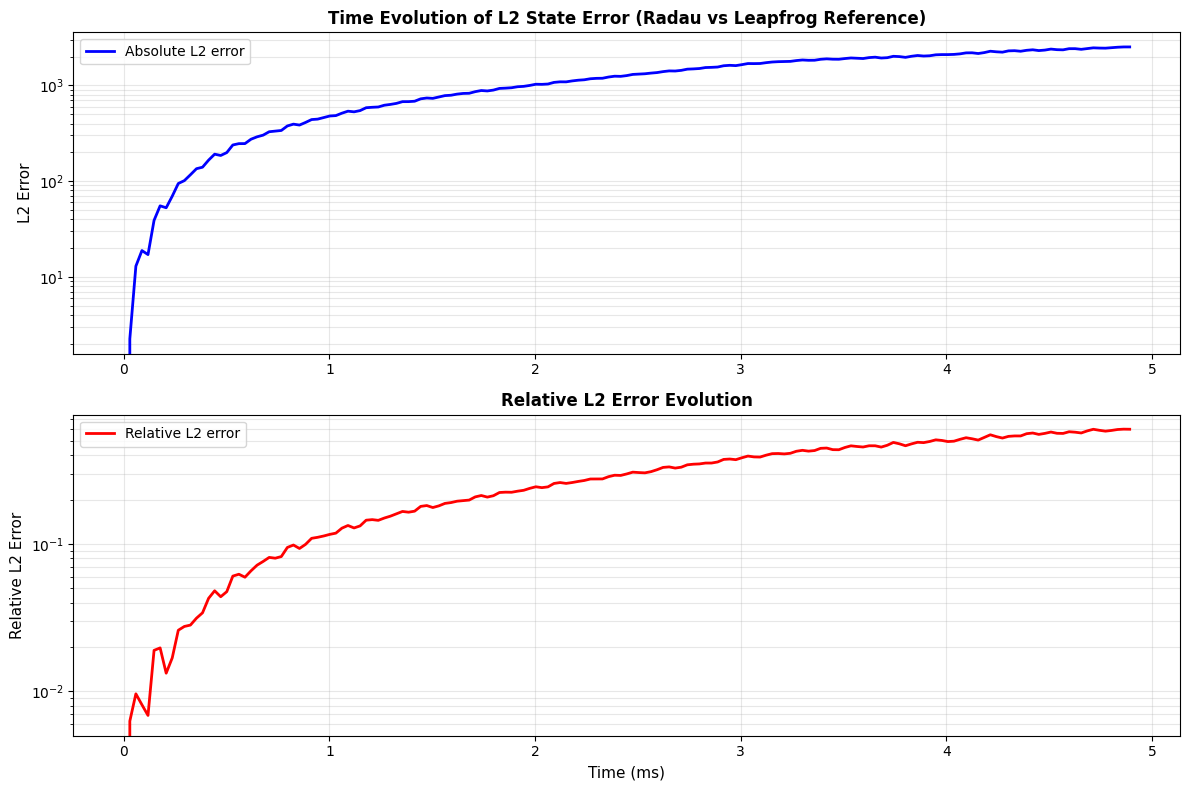

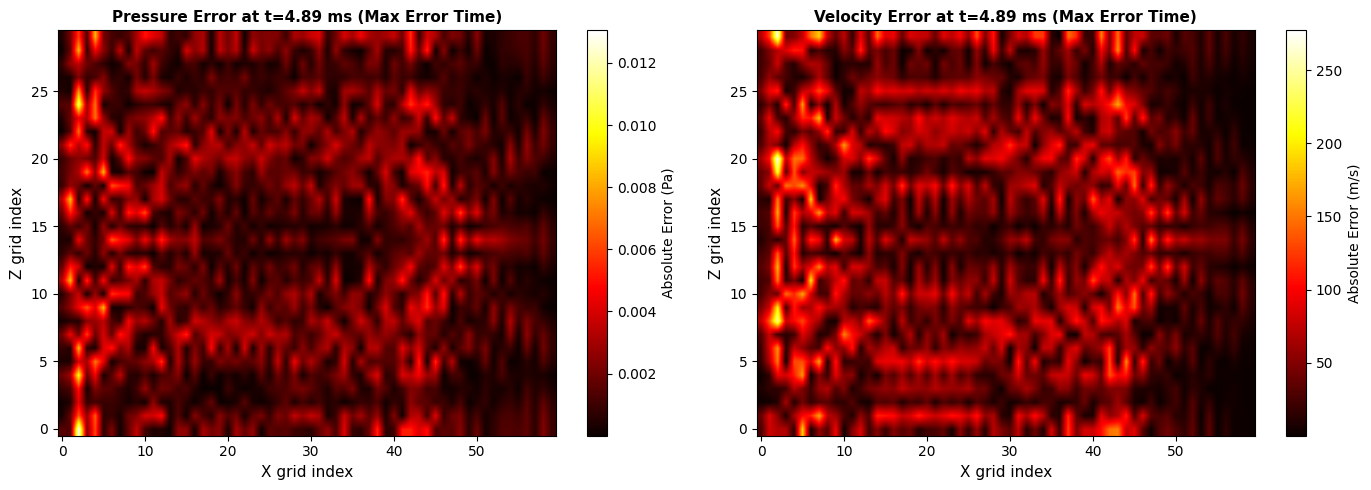


✓ Error analysis complete


In [36]:
# Compare Radau solution against reference (no interpolation)
# Find matching time points between reference and Radau solution

print(f"{'='*60}")
print(f"Error Analysis: Radau vs Leapfrog Reference")
print(f"{'='*60}")
print(f"Reference: {len(ref_small['t'])} points at dt={ref_small['dt']*1e6:.2f} μs")
print(f"Radau:     {len(t_radau)} points at dt≈{dt_trap*1e6:.2f} μs (max)")
print()

# Find indices in reference that match Radau time points (within tolerance)
matching_indices = []
radau_indices = []
tolerance = ref_small['dt'] / 2  # Half of reference timestep

for i, t_r in enumerate(t_radau):
    # Find closest reference time
    time_diffs = np.abs(ref_small['t'] - t_r)
    min_idx = np.argmin(time_diffs)
    
    if time_diffs[min_idx] < tolerance:
        matching_indices.append(min_idx)
        radau_indices.append(i)

print(f"Found {len(matching_indices)} matching time points")
print(f"Time range: [{ref_small['t'][matching_indices[0]]*1e3:.2f}, {ref_small['t'][matching_indices[-1]]*1e3:.2f}] ms\n")

# Extract matching states
X_ref_matched = ref_small['X'][:, matching_indices]
X_radau_matched = X_radau[:, radau_indices]
t_matched = ref_small['t'][matching_indices]

# Compute pointwise errors
error_abs = np.abs(X_radau_matched - X_ref_matched)
error_rel = error_abs / (np.abs(X_ref_matched) + 1e-12)

# Time-wise error (L2 norm of state difference at each time)
error_L2_time = np.sqrt(np.sum(error_abs**2, axis=0))
error_L2_rel_time = error_L2_time / (np.sqrt(np.sum(X_ref_matched**2, axis=0)) + 1e-12)

# Spatial error (max error over time for each state component)
error_max_spatial = np.max(error_abs, axis=1)

# Global error metrics
print(f"{'='*60}")
print(f"Global Error Metrics")
print(f"{'='*60}")
print(f"Max absolute error:     {np.max(error_abs):.3e}")
print(f"RMS error:              {np.sqrt(np.mean(error_abs**2)):.3e}")
print(f"Max relative error:     {np.max(error_rel):.3e}")
print(f"\nFinal time error:")
print(f"  L2 norm (absolute):   {error_L2_time[-1]:.3e}")
print(f"  L2 norm (relative):   {error_L2_rel_time[-1]:.3e}")
print(f"{'='*60}\n")

# Create visualization: Time-wise error evolution
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: L2 error over time
ax = axes[0]
ax.semilogy(t_matched*1e3, error_L2_time, 'b-', linewidth=2, label='Absolute L2 error')
ax.set_ylabel('L2 Error', fontsize=11)
ax.set_title('Time Evolution of L2 State Error (Radau vs Leapfrog Reference)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, which='both')
ax.legend()

# Plot 2: Relative L2 error over time
ax = axes[1]
ax.semilogy(t_matched*1e3, error_L2_rel_time, 'r-', linewidth=2, label='Relative L2 error')
ax.set_xlabel('Time (ms)', fontsize=11)
ax.set_ylabel('Relative L2 Error', fontsize=11)
ax.set_title('Relative L2 Error Evolution', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, which='both')
ax.legend()

plt.tight_layout()
plt.show()

# Create spatial error heatmap
# Reshape errors to 2D grid (pressure and velocity components)
N = ref_small['p']['Nx'] * ref_small['p']['Nz']
Nx = ref_small['p']['Nx']
Nz = ref_small['p']['Nz']

# Find time index with maximum error for visualization
max_error_time_idx = np.argmax(error_L2_time)
t_max_error = t_matched[max_error_time_idx]

# Extract pressure field errors at max error time
pressure_error = error_abs[:N, max_error_time_idx]
pressure_error_2d = pressure_error.reshape(Nx, Nz)

# Create heatmap
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pressure error heatmap
ax = axes[0]
im1 = ax.imshow(pressure_error_2d.T, origin='lower', aspect='auto', 
                cmap='hot', interpolation='bilinear')
ax.set_xlabel('X grid index', fontsize=11)
ax.set_ylabel('Z grid index', fontsize=11)
ax.set_title(f'Pressure Error at t={t_max_error*1e3:.2f} ms (Max Error Time)', 
             fontsize=11, fontweight='bold')
plt.colorbar(im1, ax=ax, label='Absolute Error (Pa)')

# Velocity error heatmap
velocity_error = error_abs[N:, max_error_time_idx]
velocity_error_2d = velocity_error.reshape(Nx, Nz)

ax = axes[1]
im2 = ax.imshow(velocity_error_2d.T, origin='lower', aspect='auto', 
                cmap='hot', interpolation='bilinear')
ax.set_xlabel('X grid index', fontsize=11)
ax.set_ylabel('Z grid index', fontsize=11)
ax.set_title(f'Velocity Error at t={t_max_error*1e3:.2f} ms (Max Error Time)', 
             fontsize=11, fontweight='bold')
plt.colorbar(im2, ax=ax, label='Absolute Error (m/s)')

plt.tight_layout()
plt.show()

print(f"\n✓ Error analysis complete")

Hydrophone Signal Comparison
Reference: Leapfrog at dt=7.37 μs
Radau:     Implicit solver at dt≈29.46 μs



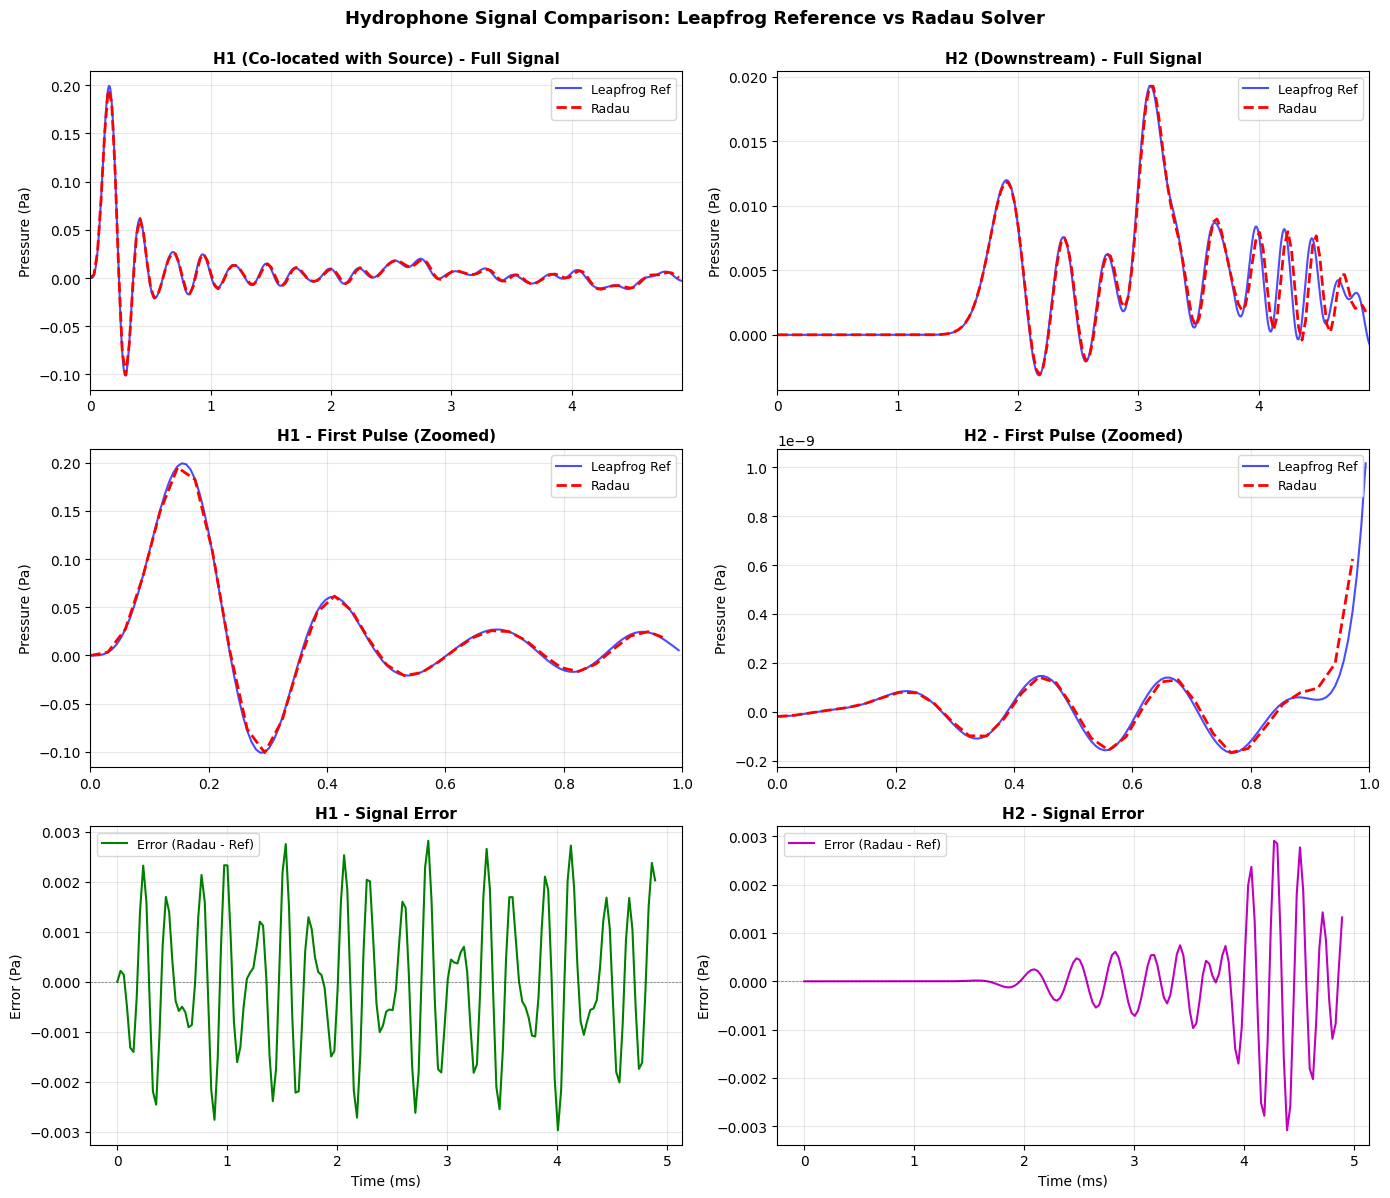


Hydrophone Signal Error Statistics:
H1 (Co-located):
  Max absolute error: 2.974e-03 Pa
  RMS error:          1.406e-03 Pa
  Max signal:         1.964e-01 Pa
  Relative error:     1.51%

H2 (Downstream):
  Max absolute error: 3.082e-03 Pa
  RMS error:          8.211e-04 Pa
  Max signal:         1.925e-02 Pa
  Relative error:     16.01%

✓ Hydrophone comparison complete


In [38]:
# Visualize hydrophone outputs: Reference vs Radau solution

# Extract hydrophone signals from Radau solution
y_radau = np.zeros((2, len(t_radau)))
for i in range(len(t_radau)):
    y_radau[:, i] = eval_g_Sonar(X_radau[:, i].reshape(-1, 1), p).flatten()

# Extract hydrophone signals from reference at matching time points
y_ref_matched = np.zeros((2, len(matching_indices)))
for i, idx in enumerate(matching_indices):
    y_ref_matched[:, i] = eval_g_Sonar(ref_small['X'][:, idx].reshape(-1, 1), ref_small['p']).flatten()

print(f"{'='*60}")
print(f"Hydrophone Signal Comparison")
print(f"{'='*60}")
print(f"Reference: Leapfrog at dt={ref_small['dt']*1e6:.2f} μs")
print(f"Radau:     Implicit solver at dt≈{dt_trap*1e6:.2f} μs")
print(f"{'='*60}\n")

# Create comprehensive comparison plot
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# H1 (co-located with source) - Full time series
ax = axes[0, 0]
ax.plot(ref_small['t']*1e3, y_ref_small[0, :], 'b-', linewidth=1.5, alpha=0.7, label='Leapfrog Ref')
ax.plot(t_radau*1e3, y_radau[0, :], 'r--', linewidth=2, label='Radau')
ax.set_ylabel('Pressure (Pa)', fontsize=10)
ax.set_title('H1 (Co-located with Source) - Full Signal', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)
ax.set_xlim([0, t_stop*1e3])

# H2 (downstream) - Full time series
ax = axes[0, 1]
ax.plot(ref_small['t']*1e3, y_ref_small[1, :], 'b-', linewidth=1.5, alpha=0.7, label='Leapfrog Ref')
ax.plot(t_radau*1e3, y_radau[1, :], 'r--', linewidth=2, label='Radau')
ax.set_ylabel('Pressure (Pa)', fontsize=10)
ax.set_title('H2 (Downstream) - Full Signal', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)
ax.set_xlim([0, t_stop*1e3])

# H1 - Zoomed to first pulse
ax = axes[1, 0]
zoom_end = 1.0  # First 1 ms
zoom_mask_ref = ref_small['t'] <= zoom_end * 1e-3
zoom_mask_radau = t_radau <= zoom_end * 1e-3
ax.plot(ref_small['t'][zoom_mask_ref]*1e3, y_ref_small[0, zoom_mask_ref], 
        'b-', linewidth=1.5, alpha=0.7, label='Leapfrog Ref')
ax.plot(t_radau[zoom_mask_radau]*1e3, y_radau[0, zoom_mask_radau], 
        'r--', linewidth=2, label='Radau')
ax.set_ylabel('Pressure (Pa)', fontsize=10)
ax.set_title('H1 - First Pulse (Zoomed)', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)
ax.set_xlim([0, zoom_end])

# H2 - Zoomed to first pulse
ax = axes[1, 1]
ax.plot(ref_small['t'][zoom_mask_ref]*1e3, y_ref_small[1, zoom_mask_ref], 
        'b-', linewidth=1.5, alpha=0.7, label='Leapfrog Ref')
ax.plot(t_radau[zoom_mask_radau]*1e3, y_radau[1, zoom_mask_radau], 
        'r--', linewidth=2, label='Radau')
ax.set_ylabel('Pressure (Pa)', fontsize=10)
ax.set_title('H2 - First Pulse (Zoomed)', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)
ax.set_xlim([0, zoom_end])

# H1 - Error over time
ax = axes[2, 0]
error_h1 = y_radau[0, radau_indices] - y_ref_matched[0, :]
ax.plot(t_matched*1e3, error_h1, 'g-', linewidth=1.5, label='Error (Radau - Ref)')
ax.axhline(y=0, color='k', linestyle='--', linewidth=0.5, alpha=0.5)
ax.set_xlabel('Time (ms)', fontsize=10)
ax.set_ylabel('Error (Pa)', fontsize=10)
ax.set_title('H1 - Signal Error', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)

# H2 - Error over time
ax = axes[2, 1]
error_h2 = y_radau[1, radau_indices] - y_ref_matched[1, :]
ax.plot(t_matched*1e3, error_h2, 'm-', linewidth=1.5, label='Error (Radau - Ref)')
ax.axhline(y=0, color='k', linestyle='--', linewidth=0.5, alpha=0.5)
ax.set_xlabel('Time (ms)', fontsize=10)
ax.set_ylabel('Error (Pa)', fontsize=10)
ax.set_title('H2 - Signal Error', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)

plt.suptitle('Hydrophone Signal Comparison: Leapfrog Reference vs Radau Solver', 
             fontsize=13, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Print error statistics for hydrophone signals
print(f"\nHydrophone Signal Error Statistics:")
print(f"{'='*60}")
print(f"H1 (Co-located):")
print(f"  Max absolute error: {np.max(np.abs(error_h1)):.3e} Pa")
print(f"  RMS error:          {np.sqrt(np.mean(error_h1**2)):.3e} Pa")
print(f"  Max signal:         {np.max(np.abs(y_ref_matched[0, :])):.3e} Pa")
print(f"  Relative error:     {np.max(np.abs(error_h1))/np.max(np.abs(y_ref_matched[0, :]))*100:.2f}%")
print(f"\nH2 (Downstream):")
print(f"  Max absolute error: {np.max(np.abs(error_h2)):.3e} Pa")
print(f"  RMS error:          {np.sqrt(np.mean(error_h2**2)):.3e} Pa")
print(f"  Max signal:         {np.max(np.abs(y_ref_matched[1, :])):.3e} Pa")
print(f"  Relative error:     {np.max(np.abs(error_h2))/np.max(np.abs(y_ref_matched[1, :]))*100:.2f}%")
print(f"{'='*60}\n")

print("✓ Hydrophone comparison complete")